<a href="https://colab.research.google.com/github/syKevinPeng/smpl2motorica/blob/main/playground/smpl_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import cv2
import smplx
import torch
from tqdm import tqdm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_SMPL_skeleton_names():
    return [
        "pelvis",
        "left_hip",
        "right_hip",
        "spine1",
        "left_knee",
        "right_knee",
        "spine2",
        "left_ankle",
        "right_ankle",
        "spine3",
        "left_foot",
        "right_foot",
        "neck",
        "left_collar",
        "right_collar",
        "head",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_hand",
        "right_hand",
    ]


def SMPL_output_video(joints, vertices, model):
    for i in tqdm(range(joints.shape[0]), desc="Generating SMPL video"):
        fig = plt.figure(figsize=(10, 10))
        ax = SMPL_visulize_a_frame(fig, joints[i], vertices[i], model)
        ax.set_title(f"SMPL frame {i}")
        plt.savefig(f"smpl_frame_{i:04d}.png")
        plt.close(fig)

    # compile the video
    image_folder = "."
    video_name = "smpl_video.mp4"
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    fps = 6  # Set frames per second
    video = cv2.VideoWriter(
        video_name, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height)
    )

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
    # remove the images
    for image in images:
        os.remove(os.path.join(image_folder, image))

    return video_name



# Visualize SMPL model from the asit dataset


In [ ]:
def SMPL_visulize_a_frame(joints, vertices, model, output_name="test.png"):
    from vispy.scene.visuals import Mesh, Markers, Text
    from vispy.io import write_png
    from vispy import scene
    from vispy.app import use_app
    # use_app('ipynb_webgl')

    # Create a canvas and view
    canvas = scene.SceneCanvas(keys="interactive", size=(800, 600), show=True)
    view = canvas.central_widget.add_view()
    view.camera = "turntable"

    # Center and adjust the camera
    view.camera.center = vertices.mean(axis=0)
    view.camera.distance = np.linalg.norm(vertices.max(axis=0) - vertices.min(axis=0)) * 2

    # Create a mesh visual for the SMPL model
    mesh = Mesh(
        vertices=vertices,
        faces=model.faces,
        color=(1.0, 1.0, 0.9, 1.0)  # Fully opaque
    )
    view.add(mesh)

    # Create a scatter visual for the joints
    scatter = Markers()
    scatter.set_data(joints, face_color="red", size=10)
    view.add(scatter)

    # Add joint names as text visuals
    joint_names = get_SMPL_skeleton_names()
    for i, joint in enumerate(joints):
        text = Text(
            f"{i}:{joint_names[i]}",
            pos=joint,
            color="blue",
            font_size=10,
            anchor_x="left",
            anchor_y="bottom",
        )
        view.add(text)

    # Return the canvas for display in Jupyter
    return canvas

## Loading the file


In [ ]:
amass_data_root = Path("../data/AIST++/gBR_sBM_cAll_d04_mBR0_ch01.pkl")
smpl_model_path = Path("/content/drive/MyDrive/smpl/models")
if not amass_data_root.exists():
    raise FileNotFoundError(f"AMASS data root {amass_data_root} does not exist. ")
if not smpl_model_path.is_dir():
    raise FileNotFoundError(f"SMPL model path {smpl_model_path} does not exist. ")


# load the data
data = np.load(amass_data_root, allow_pickle=True)
print(data.keys())
# sample every 10 frames => 6fps
sample_indices = np.arange(0, data["smpl_poses"].shape[0], 10)
poses = data["smpl_poses"][sample_indices]
root_trans = data["smpl_trans"][sample_indices]
scale = data["smpl_scaling"].reshape(1, 1)
# create human model
smpl_model = smplx.create(
    model_path=smpl_model_path,
    model_type="smpl",
    return_verts=True,
    batch_size=len(poses),
)

dict_keys(['smpl_loss', 'smpl_poses', 'smpl_scaling', 'smpl_trans'])


In [ ]:
smpl_body_pose = poses[:, 3:]
smpl_root_rot = poses[:, :3]
# force the root rotation to be zero
root_trans = root_trans - root_trans[0]
# root_trans = np.zeros_like(root_trans)

smpl_output = smpl_model(
    global_orient=torch.tensor(smpl_root_rot, dtype=torch.float32),
    body_pose=torch.tensor(smpl_body_pose, dtype=torch.float32),
    transl=torch.tensor(root_trans, dtype=torch.float32),
    # global_orient = torch.tensor(smpl_root_rot, dtype=torch.float32),
    scale=torch.tensor(scale, dtype=torch.float32),
)
smpl_joints_loc = smpl_output.joints.detach().cpu().numpy().squeeze()
smpl_vertices = smpl_output.vertices.detach().cpu().numpy().squeeze()

In [ ]:
# np.set_printoptions(suppress=True)
# np.round(root_trans, 2)

In [ ]:
smpl_joints_loc = smpl_joints_loc[:, : len(get_SMPL_skeleton_names()), :]


In [ ]:
import jupyter_rfb
jupyter_rfb

<module 'jupyter_rfb' from 'c:\\Users\\siyuan\\micromamba\\envs\\python310\\lib\\site-packages\\jupyter_rfb\\__init__.py'>

RFBOutputContext()

?


CanvasBackend(css_height='600px', css_width='800px')
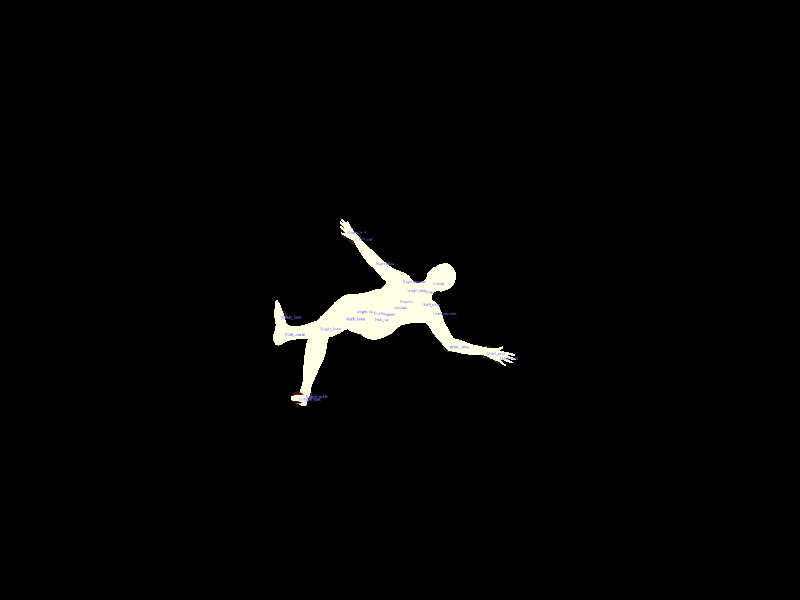

In [ ]:
# visualize a frame
frame_idx = 0
canvas = SMPL_visulize_a_frame(
smpl_joints_loc[frame_idx], smpl_vertices[frame_idx], smpl_model
)
print('?')
canvas

In [ ]:
# generate a video
# SMPL_output_video(smpl_joints_loc, smpl_vertices, smpl_model)

In [ ]:
import vispy
vispy.__version__

'0.14.3'